In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis
from torchsummary import summary
import matplotlib.pyplot as plt

In [3]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:0


In [4]:
# Prepare CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean, std
])
BATCH_SIZE = 32
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
# resnet
resnet = models.resnet18(pretrained=True)
num_classes = 10
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Summarize the model
summary(resnet, (3, 224, 224), device='cuda' if str(device) == 'cuda:0' else 'cpu')
flops = FlopCountAnalysis(resnet, torch.randn(1, 3, 224, 224).to(device))
print("FLOPs: {:.2f}GFLOPS".format(flops.total() / 1e9))

Unsupported operator aten::add_ encountered 28 time(s)
Unsupported operator aten::max_pool2d encountered 1 time(s)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [7]:
# Hyper-parameters
num_epochs = 5
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

# Directory to save checkpoints
checkpoint_dir = 'checkpoints/resnet'

# Create the checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Function to save checkpoint
def save_checkpoint(epoch):
    checkpoint_filename = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': resnet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_filename)
    print(f'Checkpoint saved at {checkpoint_filename}')

# Check if there is an existing checkpoint file
checkpoint_filename = os.path.join(checkpoint_dir, 'latest_checkpoint.pth')
if os.path.exists(checkpoint_filename):
    checkpoint = torch.load(checkpoint_filename)
    starting_epoch = checkpoint['epoch'] + 1
    resnet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    print(f'Resuming training from epoch {starting_epoch}')
else:
    starting_epoch = 0

# Record training process
train_losses = []

# Train the model
total_step = len(train_loader)
for epoch in range(starting_epoch, num_epochs):
    progress_bar = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Record training loss
        train_losses.append(loss.item())

        # Print training information
        progress_bar.set_description(
            'Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Test the model
    resnet.eval()
    train_acc = 0
    test_acc = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        test_acc += (predicted == labels).sum().item()
    train_acc /= len(train_dataset)
    test_acc /= len(test_dataset)
    print('Epoch [{}/{}], Loss: {:.4f}, Train Acc: {:.4f}, Test Acc: {:.4f}'
          .format(epoch + 1, num_epochs, loss.item(), train_acc, test_acc))
    resnet.train()

    # Save checkpoint at the end of each epoch
    save_checkpoint(epoch)
    
# Save the latest checkpoint
save_checkpoint(num_epochs - 1)

Epoch: [1/5], Step: [6/1563], Loss: 1.5791:   0%|          | 6/1563 [00:11<51:16,  1.98s/it]


KeyboardInterrupt: 

In [ ]:
# test the model
resnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test images: {100 * correct / total} %')

KeyboardInterrupt: 

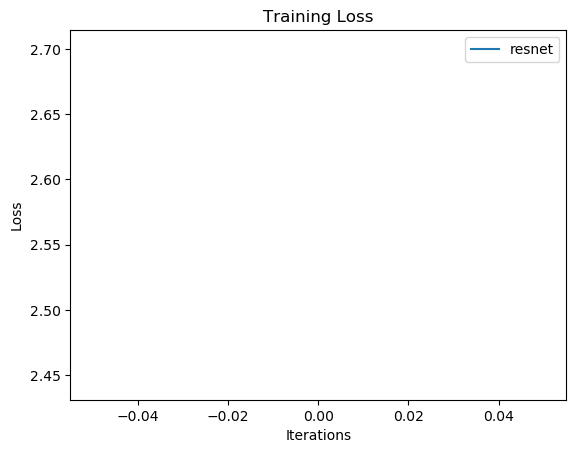

In [ ]:
# plot training loss curve(plot each 100 iterations)
plt.plot(train_losses[::100], label='resnet')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

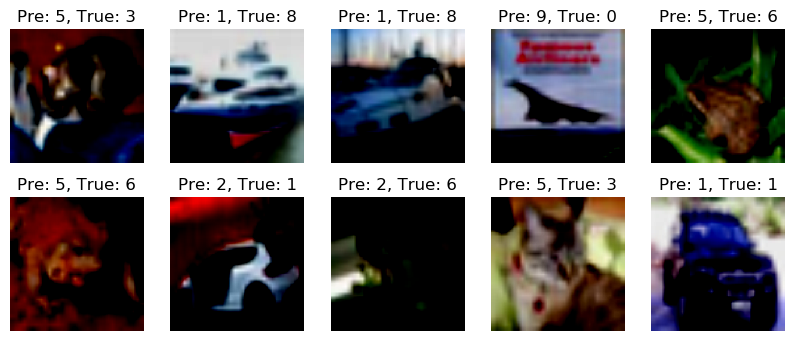

In [8]:
# show 10 random images and the prediction result(2x5)
resnet.eval()
with torch.no_grad():
    plt.figure(figsize=(10, 4))
    for i in range(10):
        images, labels = test_dataset[i]
        images = images.to(device)
        outputs = resnet(images.unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        plt.subplot(2, 5, i + 1)
        plt.imshow(images.permute(1, 2, 0).cpu())
        plt.title("Pre: {}, True: {}".format(predicted.item(), labels))
        plt.axis('off')
    plt.show()

In [9]:
# inference speed test
import time
resnet.eval()
with torch.no_grad():
    images = torch.randn(1, 3, 224, 224).to(device)
    start = time.time()
    for i in range(100):
        outputs = resnet(images)
    end = time.time()
    print("Inference time of 100 forward passes: {:.2f}ms".format((end - start) * 1000 / 100))

Inference time of 100 forward passes: 24.38ms
